**About** : This notebook is used to infer models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/tviel/work/kaggle_rsna_lumbar_spine/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Imports

In [3]:
import os
import gc
import re
import sys
import cv2
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [4]:
from inference.lvl1 import Config
from inference.crop import get_crops

from util.torch import load_model_weights
from util.plots import plot_mask, add_rect

from data.transforms import get_transfos
from data.dataset import CropDataset

from inference.seg import get_crops
from inference.processing import process
from inference.lvl1 import predict, ImageInfDataset


from model_zoo.models import define_model
from model_zoo.models_lvl2 import define_model as define_model_2
from model_zoo.models_seg import define_model as define_model_seg
from model_zoo.models_seg import convert_3d


from params import CLASSES_SEG, MODES, LEVELS_

### Params

In [5]:
EVAL = False
DEBUG = True

In [6]:
DATA_PATH = "../input/test_images/"

if DEBUG:
    if EVAL:
        DATA_PATH = "../input/train_images/"
    else:
        DATA_PATH = "../input/debug_images/"

SAVE_FOLDER = "../output/tmp/"

In [7]:
BATCH_SIZE = 32
BATCH_SIZE_2 = 512
USE_FP16 = True
NUM_WORKERS = 2


FOLD = 0 if DEBUG else "fullfit_0"
PLOT = DEBUG

In [8]:
exp_folders = {
    "nfn": "../logs/2024-08-05/27/",
    "scs": "../logs/2024-08-04/33/",
    "ss": "../logs/2024-08-06/17/",  # NEEDS IMPROVEMENT
    "ss_aux": "../logs/2024-08-06/17/",
    "scs_crop": "../logs/2024-08-07/19/",
    "nfn_crop": "../logs/2024-08-07/32/",
}

In [9]:
EXP_FOLDERS = {
    "scs": ("../logs/2024-08-04/33/", [FOLD]),
    "nfn": ("../logs/2024-08-05/27/", [FOLD]),
    "ss": ("../logs/2024-08-06/17/", [FOLD]),
}

CROP_EXP_FOLDERS = {
    "scs_crop": ("../logs/2024-08-07/19/", [FOLD]),
    "nfn_crop": ("../logs/2024-08-07/32/", [FOLD]),
}

EXP_FOLDERS_2 = [
    "../logs/2024-08-08/1/",
]

EXP_FOLDER_3D = "../logs/2024-07-31/25/"

FOLDS_2 = [0, 1, 2, 3]
if "fullfit" not in str(FOLD):
    FOLDS_2 = [FOLD]
    
    
for f in EXP_FOLDERS_2:
    folders = Config(json.load(open(f + "config.json", 'r'))).exp_folders
    print(f)
    print(folders)
    print()

../logs/2024-08-08/1/
{'nfn': '../logs/2024-08-05/27/', 'scs': '../logs/2024-08-04/33/', 'ss': '../logs/2024-08-06/17/', 'ss_aux': '../logs/2024-08-06/17/', 'scs_crop': '../logs/2024-08-07/19/', 'nfn_crop': '../logs/2024-08-07/32/'}



## Seg & Level 1

In [10]:
config_seg = Config(json.load(open(EXP_FOLDER_3D + "config.json", "r")))

model_seg = define_model_seg(
    config_seg.decoder_name,
    config_seg.name,
    num_classes=config_seg.num_classes,
    num_classes_aux=config_seg.num_classes_aux,
    increase_stride=config_seg.increase_stride,
    use_cls=config_seg.use_cls,
    n_channels=config_seg.n_channels,
    use_3d=config_seg.use_3d,
    pretrained=False,
)

model_seg = load_model_weights(model_seg, EXP_FOLDER_3D + f"{config_seg.name}_{FOLD}.pt")
model_seg = model_seg.cuda()
# model_seg = model_seg.eval()  # Hurts results ??


 -> Loading encoder weights from ../logs/2024-07-31/25/resnet34d_0.pt



In [11]:
models = {}
for mode in EXP_FOLDERS:
    exp_folder, folds = EXP_FOLDERS[mode]
    print(f'- Mode: {mode}')
    config = Config(json.load(open(exp_folder + "config.json", "r")))

    models_ = []
    for fold in folds:
        model = define_model(
            config.name,
            drop_rate=config.drop_rate,
            drop_path_rate=config.drop_path_rate,
            use_gem=config.use_gem,
            num_classes=config.num_classes,
            num_classes_aux=config.num_classes_aux,
            n_channels=config.n_channels,
            reduce_stride=config.reduce_stride,
            increase_stride=config.increase_stride if hasattr(config, "increase_stride") else False,
            pretrained=False,
        )
        model = model.cuda().eval()

        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
        models_.append(model)
        
    models[mode] = models_

- Mode: scs

 -> Loading encoder weights from ../logs/2024-08-04/33/coat_lite_medium_384_0.pt

- Mode: nfn

 -> Loading encoder weights from ../logs/2024-08-05/27/coatnet_rmlp_2_rw_384_0.pt

- Mode: ss

 -> Loading encoder weights from ../logs/2024-08-06/17/coat_lite_medium_0.pt



In [12]:
PLOT = False

In [13]:
# %%time

dfs = []
for study in tqdm(sorted(os.listdir(DATA_PATH))):
    for series in sorted(os.listdir(DATA_PATH + study)):
        print("\n-> study", study, '- Series', series)

        imgs, orient, weighting = process(
            study,
            series,
            data_path=DATA_PATH,
            on_gpu=False,
        )

        dfs.append({
            "study_id": study,
            "series_id": series,
            "orient": orient,
            "weighting": weighting,
        })

        print(f'- Orient {orient} - Weighting {weighting}')
        
        # Segmentation
        if orient == "Sagittal":
            x = imgs[:, ::-1].copy().astype(np.float32)

            with torch.inference_mode():
                x = torch.from_numpy(x).cuda()
                x = F.interpolate(
                    x.unsqueeze(0).unsqueeze(0),
                    config_seg.img_size,
                    mode="trilinear",
                )
                x = (x - x.min()) / (x.max() - x.min())

                mask, _ = model_seg(x)
                mask = F.interpolate(
                    mask,
                    imgs.shape,
                    mode="trilinear",
                )[0].argmax(0)
            mask = mask.cpu().numpy()[:, ::-1].astype(np.uint8)

            if DEBUG:
                img_ref = np.load(f"../input/npy/{study}_{series}.npy")
                mask_ref = np.load(f"../input/train_segs/{study}_{series}.npy")
                delta = (np.abs(mask - mask_ref) > 0).mean()
                print('Mask delta:', delta)
                delta = (np.abs(imgs - img_ref) > 0).mean()
                print('Img delta:', delta)

            if PLOT:
                f = len(imgs) // 2
                plt.figure(figsize=(4, 4))
                plot_mask(imgs[f], mask[f])
                plt.show()

            # Cropping
            disk_crops = {}        
            for disk in CLASSES_SEG[5:]:
                x0, x1, y0, y1, z0, z1 = get_crops(mask, disk=disk)
                disk_crops[disk] = (x0, x1, y0, y1, z0, z1)
                
                img_crop = imgs[x0: x1, y0:y1, z0:z1]
                # mask_crop = mask[x0: x1, y0:y1, z0:z1]
                
                d = re.sub('/', '_', disk.lower())
                np.save(SAVE_FOLDER + f'{study}_{series}_{d}.npy', img_crop.copy())


            if PLOT:
                plt.figure(figsize=(8, 8))
                plot_mask(imgs[f], mask[f])

                for d, disk in enumerate(disk_crops):
                    x0, x1, y0, y1, z0, z1 = disk_crops[disk]
                    add_rect(x0, x1, y0, y1, z0, z1, f, col="skyblue")
                    plt.text(10, (d + 1) * 20, f'{disk} disk center frame: {int((x1 + x0) / 2)}', color="skyblue")
                plt.show()

        # Cls
        mode = MODES[weighting + "_" + orient]
        exp_folder, models_list = EXP_FOLDERS[mode][0], models[mode]
        
        config = Config(json.load(open(exp_folder + "config.json", "r")))

        imgs = (imgs - imgs.min()) / (imgs.max() - imgs.min()) * 255
        imgs = imgs.astype(np.uint8)

        transforms = get_transfos(augment=False, resize=config.resize, crop=config.crop)
        dataset = ImageInfDataset(
            imgs,
            transforms=transforms,
            frames_chanel=config.frames_chanel if hasattr(config, "frames_chanel") else 0,
            n_frames=config.n_frames if hasattr(config, "n_frames") else 1,
            stride=config.stride if hasattr(config, "stride") else 1,
        )

        preds = []
        for model in models_list:
            pred, pred_aux = predict(
                model,
                dataset,
                config.loss_config,
                batch_size=BATCH_SIZE,
                use_fp16=USE_FP16,
                num_workers=NUM_WORKERS,
            )
            preds.append(pred)
        preds = np.mean(preds, 0)

        if PLOT:
            plt.figure(figsize=(8, 5))
            plt.plot(preds[:, :, 0])
            plt.show()

        np.save(SAVE_FOLDER + f"{study}_{series}_{mode}.npy", preds)

        # break
    break

# df = pd.concat(dfs, ignore_index=True)
# df = df.groupby(['study', 'series']).max().reset_index()

# del model_seg, models, imgs, x, pred, seg, dataset
# torch.cuda.empty_cache()
# gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]


-> study 4003253 - Series 1054713880
- Orient Sagittal - Weighting T1
Mask delta: 0.0
Img delta: 0.0

-> study 4003253 - Series 2448190387
- Orient Axial - Weighting T2

-> study 4003253 - Series 702807833
- Orient Sagittal - Weighting T2
Mask delta: 0.0
Img delta: 0.0


In [14]:
if DEBUG:
    for study in sorted(os.listdir(DATA_PATH)):
        for series in sorted(os.listdir(DATA_PATH + study)):
            print("-> study", study, '- Series', series)
            for mode in EXP_FOLDERS:
                exp_folder, folds = EXP_FOLDERS[mode]
                try:
                    preds_ref = np.load(exp_folder + f'preds/{study}_{series}.npy')
                except:
                    continue
            
                preds = np.load(SAVE_FOLDER + f'{study}_{series}_{mode}.npy')

                assert preds.shape == preds_ref.shape

                delta = ((preds - preds_ref) ** 2).max()
                print(f"{mode} delta :", delta)

-> study 4003253 - Series 1054713880
nfn delta : 0.0
-> study 4003253 - Series 2448190387
ss delta : 0.0
-> study 4003253 - Series 702807833
scs delta : 0.0


## Crop models

In [21]:
df = pd.DataFrame(dfs)

df['mode'] = (df["weighting"] + "_" + df["orient"]).map(MODES) + "_crop"
df['target'] = 0
df['coords']= 0

df['level'] = [LEVELS_ for _ in range(len(df))]
df = df.explode('level').reset_index(drop=True)
df['img_path'] = SAVE_FOLDER + df['study_id'] + "_" + df['series_id'] + "_" + df['level'] + ".npy"

In [22]:
if DEBUG:
    df['img_path_ref'] = "../input/crops_fix/" + df['study_id'] + "_" + df['series_id'] + "_" + df['level'] + ".npy"

    for i in range(len(df)):
        path_ref = df['img_path_ref'][i]
        path = df['img_path'][i]

        if os.path.exists(path_ref):
            crop_ref = np.load(path_ref)
            crop = np.load(path)

            print(f"Crop {path.split('/')[-1][:-4]} delta:\t", ((crop_ref - crop) ** 2).max())

    # df['img_path'] = df['img_path_ref']

Crop 4003253_1054713880_l1_l2 delta:	 0.0
Crop 4003253_1054713880_l2_l3 delta:	 0.0
Crop 4003253_1054713880_l3_l4 delta:	 0.0
Crop 4003253_1054713880_l4_l5 delta:	 0.0
Crop 4003253_1054713880_l5_s1 delta:	 0.0
Crop 4003253_702807833_l1_l2 delta:	 0.0
Crop 4003253_702807833_l2_l3 delta:	 0.0
Crop 4003253_702807833_l3_l4 delta:	 0.0
Crop 4003253_702807833_l4_l5 delta:	 0.0
Crop 4003253_702807833_l5_s1 delta:	 0.0


{'4003253_1054713880_Left_l1_l2': array([0.995   , 0.00347 , 0.001312], dtype=float16),
 '4003253_1054713880_Left_l2_l3': array([0.995   , 0.003983, 0.001121], dtype=float16),
 '4003253_1054713880_Left_l3_l4': array([0.99    , 0.008736, 0.001153], dtype=float16),
 '4003253_1054713880_Left_l4_l5': array([0.4443, 0.522 , 0.0335], dtype=float16),
 '4003253_1054713880_Left_l5_s1': array([0.9204  , 0.075   , 0.004616], dtype=float16),
 '4003253_1054713880_Right_l1_l2': array([0.9946  , 0.004375, 0.001008], dtype=float16),
 '4003253_1054713880_Right_l2_l3': array([0.9946  , 0.004295, 0.001   ], dtype=float16),
 '4003253_1054713880_Right_l3_l4': array([9.888e-01, 1.025e-02, 8.998e-04], dtype=float16),
 '4003253_1054713880_Right_l4_l5': array([0.908   , 0.0893  , 0.002333], dtype=float16),
 '4003253_1054713880_Right_l5_s1': array([0.943  , 0.05453, 0.00242], dtype=float16)}


 -> Loading encoder weights from ../logs/2024-08-07/19/coatnet_1_rw_224_0.pt



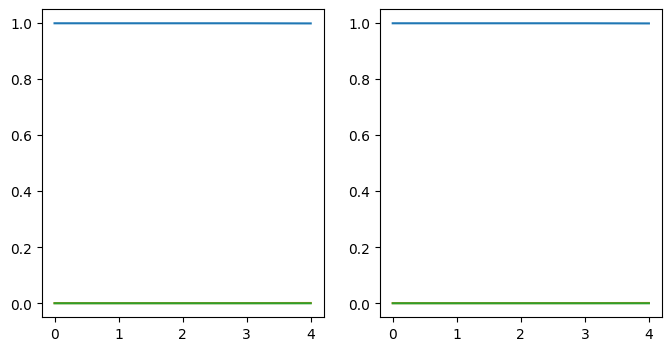

(5, 3) (5, 3)
scs_crop delta: 0.0

 -> Loading encoder weights from ../logs/2024-08-07/32/coatnet_1_rw_224_0.pt



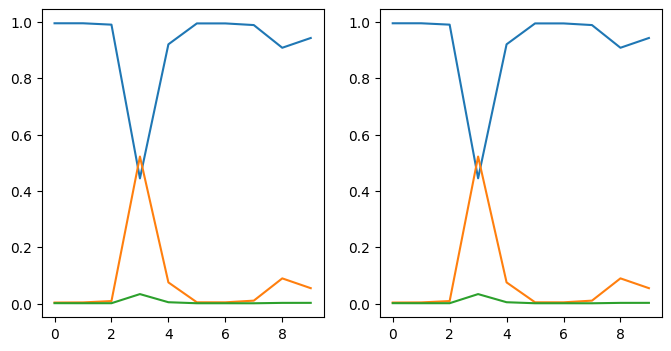

(10, 3) (10, 3)
nfn_crop delta: 0.0002441


In [136]:
crop_fts = {}
for mode in CROP_EXP_FOLDERS:
    exp_folder, folds = CROP_EXP_FOLDERS[mode]
    
    config = Config(json.load(open(exp_folder + "config.json", "r")))

    df_mode = df[df['mode'] == mode].reset_index(drop=True)
    df_mode['side'] = "Center"

    if "scs" not in mode:
        df_mode['side'] = "Right"
        df_mode_left = df_mode.copy()
        df_mode_left['side'] = "Left"
        df_mode = pd.concat([df_mode, df_mode_left]).reset_index(drop=True)
        df_mode = df_mode.sort_values(['study_id', 'series_id', 'side', 'level'], ignore_index=True)

    transfos = get_transfos(augment=False, resize=config.resize, crop=config.crop)
    dataset = CropDataset(
        df_mode,
        targets="target",
        transforms=transfos,
        frames_chanel=config.frames_chanel,
        n_frames=config.n_frames,
        stride=config.stride,
        train=False,
        load_in_ram=False,
    )

    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        use_gem=config.use_gem,
        head_3d=config.head_3d,
        n_frames=config.n_frames,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        pretrained=False
    )
    model = model.cuda().eval()
    
    preds = []
    for fold in folds:
        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=1)

        pred, _ = predict(
            model,
            dataset,
            config.loss_config,
            batch_size=BATCH_SIZE,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )
        preds.append(pred)

    preds = np.mean(preds, 0)

    if DEBUG:        
        df_ref = pd.read_csv(exp_folder + "df_val_0.csv").head(len(preds))
        order_ref = df_ref.sort_values(['side', 'level']).index.values
        preds_ref = np.load(exp_folder + "pred_inf_0.npy")[:len(preds)][order_ref]

        # print(df_ref.iloc[order_ref]['img_path'].values)
        # print(df_mode['img_path'].values)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.plot(preds)
        plt.subplot(1, 2, 2)
        plt.plot(preds_ref)
        plt.show()

        delta = (np.abs(preds - preds_ref)).max()
        print(preds.shape, preds_ref.shape)
        print(f"{mode} delta:", delta)

    idx = df_mode[['study_id', 'series_id', 'level', 'side']].values.tolist()
    idx = ['_'.join(i) for i in idx]
    crop_fts[mode] = dict(zip(idx, preds))
    
# crop_fts = np.array(crop_fts) # n_models x 3*n_studies x n_classes
# np.save(SAVE_FOLDER + "crop_fts.npy", crop_fts)

## Level 2

In [137]:
from inference.lvl2 import predict as predict_2
from inference.lvl2 import FeatureInfDataset, to_sub_format

In [225]:
class FeatureInfDataset(Dataset):
    """
    Dataset for training RNN models.
    """
    def __init__(
        self,
        df,
        exp_folders,
        crop_fts,
        resize=None,
        save_folder="../output/tmp",
    ):
        self.df = df.drop_duplicates(keep="first", subset="study_id", ignore_index=True)
        self.resize = resize
        self.exp_folders = exp_folders
        self.save_folder = save_folder

        self.series_dict = self.get_series_dict(df)

        self.sizes = {
            "nfn": resize,
            "scs": resize,
            "ss": resize * 2,
            "ss_aux": resize * 2,
        }

        self.dummies = {}
        self.fts = crop_fts

        # study = self.df["study_id"][0]
        # series = self.series_dict[study]
        # for k in self.exp_folders:
        #     else:
        #         self.dummies[k] = 0.33 + np.zeros_like(
        #             np.load(self.exp_folders[k] + f'preds/{study}_{series[k.split("_")[0]]}.npy')
        #         )

    @staticmethod
    def get_series_dict(df):
        series_dict = defaultdict(dict)
        for study, df_study in df.groupby("study_id"):
            series = df_study.set_index("series_description")["series_id"]
            for k in ["scs", "nfn", "ss"]:
                try:
                    series_dict[study][k] = int(series[k])
                except KeyError:
                    series_dict[study][k] = 0

            for k in series_dict[study]:
                if not isinstance(series_dict[study][k], int):
                    series_dict[study][k] = series_dict[study][k].values[0]

        return series_dict

    def __len__(self):
        return len(self.df)

    @staticmethod
    def resize_fts(fts, size):
        if len(fts.shape) == 2:  # Add chanel
            fts = fts[:, None]

        fts = fts.transpose(1, 2, 0)  # n x 3 x t -> t x n x 3
        fts = F.interpolate(
            torch.from_numpy(fts).float(), size=size, mode="linear"
        ).numpy()
        fts = fts.transpose(2, 0, 1)
        return fts

    def __getitem__(self, idx):
        study = self.df["study_id"][idx]
        series = self.series_dict[study]

        fts = {}
        for k in self.exp_folders:
            k_ = k.split("_")[0]
            # print(k_)
            if "crop" in k:
                sides = ['Center'] if "scs" in k else ["Left", "Right"]
                ft = []
                for lvl in LEVELS_:
                    for side in sides:
                        # print(f'{study}_{series[k_]}_{lvl}_{side}')
                        ft.append(
                            self.fts[k].get(f'{study}_{series[k_]}_{lvl}_{side}', np.zeros(3))
                        )
                ft = np.vstack(ft)

            else:
                try:
                    ft = np.load(self.save_folder + f'{study}_{series[k_]}_{k_}.npy')
                    # print(k, ft.shape)
                except FileNotFoundError:
                    ft = self.dummies[k]

            # print(k, ft.shape)
            if k in self.sizes:
                ft = self.resize_fts(ft, self.sizes[k])
                ft = ft.reshape(self.sizes[k], -1)
            else:
                ft = ft.flatten()
            fts[k] = torch.from_numpy(ft).float().contiguous()

        return fts, 0, 0


In [226]:
from torch.utils.data import Dataset
from collections import defaultdict


In [227]:
df['series_description'] = (df['weighting'] + "_" + df['orient']).map(MODES)
df_2 = pd.DataFrame(df[["study_id", "series_id", "series_description"]].drop_duplicates(keep="first")).reset_index(drop=True)
df_2 = df_2.sort_values(["study_id", "series_id"], ignore_index=True)

In [228]:
df_2

,study_id,series_id,series_description
0,4003253,1054713880,nfn
1,4003253,2448190387,ss
2,4003253,702807833,scs


In [237]:
all_preds = []

for exp_folder in EXP_FOLDERS_2:
    config_2 = Config(json.load(open(exp_folder + "config.json", "r")))

    dataset = FeatureInfDataset(
        df_2,
        config_2.exp_folders,
        crop_fts,
        resize=config_2.resize,
        save_folder=SAVE_FOLDER,
    )
    
    model = define_model_2(
        config_2.name,
        ft_dim=config_2.ft_dim,
        layer_dim=config_2.layer_dim,
        dense_dim=config_2.dense_dim,
        p=config_2.p,
        resize=config_2.resize,
        num_classes=config_2.num_classes,
        num_classes_aux=config_2.num_classes_aux,
    )
    model = model.eval().cuda()

    for fold in FOLDS_2:
        weights = exp_folder + f"{config_2.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
    
        preds, _ = predict(
            model,
            dataset,
            config_2.loss_config,
            batch_size=BATCH_SIZE_2,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )

        if DEBUG:
            preds_ref = np.load(EXP_FOLDERS_2[0] + f"pred_val_{fold}.npy")[:1]
            delta = np.abs(preds - preds_ref).max()
            print(f"Model {exp_folder} delta:", delta)

        all_preds.append(preds)


 -> Loading encoder weights from ../logs/2024-08-08/1/baseline_0.pt

Model ../logs/2024-08-08/1/ delta: 0.0004883


In [230]:
preds = np.mean(all_preds, 0).astype(np.float64)

In [ ]:
preds = np.mean(all_preds, 0).astype(np.float64)

for i in range(preds.shape[1]):
    df[f'pred_{i}'] = preds[:, i]

dfg = df.drop(['series', 'path', 'frame', 'patient_id'], axis=1).groupby('patient').mean().reset_index()
sub = to_sub_format(dfg)

sub

In [ ]:
# sub.to_csv(SAVE_FOLDER + "submission.csv", index=False)
# sub

Done ! 